In [1]:
import pandas as pd
import requests
import numpy as np
import time
from pandas.io.json import json_normalize 
pd.set_option('display.max_columns', None)  

In [2]:
def get_data_count(url):
    data_count = requests.get(url).json()
    print("count: " + str(data_count['count']))

In [3]:
def get_data(url):
    data = requests.get(url).json()['results']
    return pd.DataFrame.from_dict(json_normalize(data))

In [4]:
def get_data_features(url):
    data = requests.get(url).json()['results']
    return pd.DataFrame.from_dict(json_normalize(data['features']))

In [5]:
url = 'http://service.civicpdx.org/transportation2019/v1/toad/busSystemWideSummary/'

In [6]:
get_data_count(url)

count: 96


In [7]:
url = 'http://service.civicpdx.org/transportation2019/v1/toad/busSystemWideSummary/?limit=96'

In [8]:
bus_summary = get_data(url)

In [9]:
bus_summary.head()

,arrive_quarter_hour,iqr_seconds_late,median_seconds_late,p05_seconds_late,p95_seconds_late,q1_seconds_late,q3_seconds_late,samples,total_offs,total_ons
0,0.00,145.0,53.0,0.0,398.0,0.0,145.0,404875,105060,94042
1,0.25,165.0,60.0,0.0,435.0,0.0,165.0,293124,99557,57983
2,0.50,133.0,47.0,0.0,429.0,0.0,133.0,237628,54659,73892
3,0.75,120.0,32.0,0.0,352.0,0.0,120.0,266591,58751,38637
4,1.00,115.0,32.0,0.0,359.0,0.0,115.0,179802,40162,30500


In [10]:
import matplotlib.pyplot as plt
import matplotlib.style as style 
style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
bus_summary.plot(x='arrive_quarter_hour', y = ['total_ons', 'total_offs', 'samples'], xticks= range(0,25))

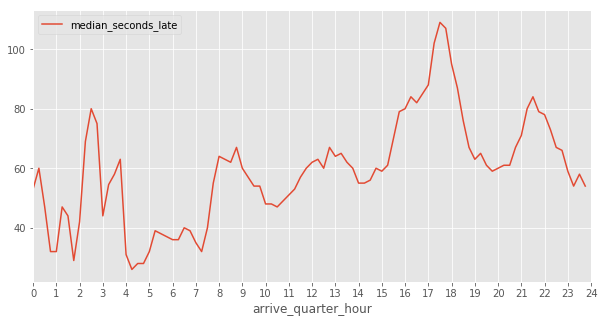

In [11]:
import matplotlib.pyplot as plt
import matplotlib.style as style 
style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
bus_summary.plot(x='arrive_quarter_hour', y = 'median_seconds_late', xticks= range(0,25))

In [12]:
url = 'http://service.civicpdx.org/transportation2019/v1/toad/busAmRushSummary'

In [13]:
get_data_count(url)

count: 9064


In [14]:
url = 'http://service.civicpdx.org/transportation2019/v1/toad/busAmRushSummary/?limit=9064'

In [15]:
am_rush = get_data_features(url)

In [16]:
am_rush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9064 entries, 0 to 9063
Data columns (total 18 columns):
geometry.coordinates              9064 non-null object
geometry.type                     9064 non-null object
id                                9064 non-null int64
properties.direction              9064 non-null int64
properties.iqr_seconds_late       9064 non-null float64
properties.latitude               9064 non-null float64
properties.location_id            9064 non-null int64
properties.longitude              9064 non-null float64
properties.median_seconds_late    9064 non-null float64
properties.p05_seconds_late       9064 non-null float64
properties.p95_seconds_late       9064 non-null float64
properties.q1_seconds_late        9064 non-null float64
properties.q3_seconds_late        9064 non-null float64
properties.route_number           9064 non-null int64
properties.samples                9064 non-null int64
properties.total_offs             9064 non-null int64
properties.

### Get bus stop names from our tmRouteStops endpoint

In [17]:
url = 'http://service.civicpdx.org/transportation2019/v1/toad/tmRouteStops/'

In [18]:
get_data_count(url)

count: 9236


In [19]:
url = 'http://service.civicpdx.org/transportation2019/v1/toad/tmRouteStops/?limit=9236'

In [20]:
tm_route_stops = get_data_features(url)

In [21]:
tm_route_stops.head()

,geometry.coordinates,geometry.type,id,properties.dir,properties.dir_desc,properties.frequent,properties.jurisdic,properties.rte,properties.rte_desc,properties.stop_id,properties.stop_name,properties.stop_seq,properties.type,properties.zipcode,type
0,"[-122.56870745476687, 45.43566941945029]",Point,1,0,To Oregon City Transit Center,False,Clackamas Co.,34,34-Linwood/River Rd,13248,Clackamas Town Center Transit Center,100,BUS,97015,Feature
1,"[-122.57400318762416, 45.43750659452653]",Point,2,0,To Oregon City Transit Center,False,Clackamas Co.,34,34-Linwood/River Rd,12922,Clackamas Town Center Mall,150,BUS,97086,Feature
2,"[-122.58502483117229, 45.43657503885296]",Point,3,0,To Oregon City Transit Center,False,Clackamas Co.,34,34-Linwood/River Rd,1936,11900 Block SE Fuller (La Salle),350,BUS,97222,Feature
3,"[-122.58703453889802, 45.434246303780824]",Point,4,0,To Oregon City Transit Center,False,Clackamas Co.,34,34-Linwood/River Rd,1940,SE Fuller & Southgate,400,BUS,97222,Feature
4,"[-122.59893110450243, 45.43409226040636]",Point,5,0,To Oregon City Transit Center,False,Milwaukie,34,34-Linwood/River Rd,3428,12300 Block SE Linwood,650,BUS,97222,Feature


In [22]:
am_rush = am_rush.merge(tm_route_stops[['properties.stop_id','properties.stop_name']], how = 'left', left_on = 'properties.location_id', right_on = 'properties.stop_id' ).fillna("")

### Plot total ons and offs at bus stops by inbound direction (often southbound)

In [23]:
am_plot_inbound = am_rush[am_rush['properties.direction'] == 1].groupby(['properties.location_id', 'properties.direction', 'properties.longitude', 'properties.latitude', 'properties.stop_name'])[['properties.total_ons', 'properties.total_offs']].sum().reset_index()

In [24]:
am_plot_inbound['properties.total_ons_and_offs'] = am_plot_inbound['properties.total_ons'] + am_plot_inbound['properties.total_offs']

In [25]:
am_plot_inbound.head()

,properties.location_id,properties.direction,properties.longitude,properties.latitude,properties.stop_name,properties.total_ons,properties.total_offs,properties.total_ons_and_offs
0,2,1,-122.675302,45.420513,,0,1,1
1,3,1,-122.665197,45.419388,A Ave & Second St,4820,212,5032
2,4,1,-122.675442,45.420685,,23,0,23
3,6,1,-122.673070,45.420221,A Ave & 8th St,2,0,2
4,7,1,-122.672680,45.420414,A Ave & 8th St,340,2,342


In [26]:
am_plot_inbound['location'] = '(' + am_plot_inbound['properties.latitude'].astype(str) + ', ' + am_plot_inbound['properties.longitude'].astype(str) + ')'

In [27]:
import math
from ast import literal_eval
def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [28]:
am_plot_inbound['coords_x'] = am_plot_inbound['location'].apply(lambda x: merc(x)[0])
am_plot_inbound['coords_y'] = am_plot_inbound['location'].apply(lambda x: merc(x)[1])

In [29]:
am_plot_inbound['circle_sizes'] = am_plot_inbound['properties.total_ons_and_offs'] / 25000

In [30]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import ColumnDataSource, HoverTool
source = ColumnDataSource(data=dict(
                        x=list(am_plot_inbound['coords_x']), 
                        y=list(am_plot_inbound['coords_y']),
                        total_ons_and_offs=list(am_plot_inbound['properties.total_ons_and_offs']),
                        total_ons=list(am_plot_inbound['properties.total_ons']),
                        total_offs=list(am_plot_inbound['properties.total_offs']),
                        sizes=list(am_plot_inbound['circle_sizes']),
                        stop_name=list(am_plot_inbound['properties.stop_name'])))
hover = HoverTool(tooltips=[
    ("stop_name", "@stop_name"),
    ("total_ons_and_offs","@total_ons_and_offs"),
    ("total_ons","@total_ons"),
    ("total_offs","@total_offs")
    
])
# range bounds supplied in web mercator coordinates
p = figure(x_axis_type="mercator", 
           y_axis_type="mercator",
           tools=[hover,'pan', 'box_zoom', 'wheel_zoom','save', 'reset'])
p.add_tile(CARTODBPOSITRON)
p.circle(x='x',
         y='y', 
         source=source,
         size='sizes',
         line_color="#1C5CA3", 
         fill_color="#1c9fa3",
         fill_alpha=0.05)
    
output_notebook()
show(p)

Loading BokehJS ...

In [31]:
am_rush.head()

,geometry.coordinates,geometry.type,id,properties.direction,properties.iqr_seconds_late,properties.latitude,properties.location_id,properties.longitude,properties.median_seconds_late,properties.p05_seconds_late,properties.p95_seconds_late,properties.q1_seconds_late,properties.q3_seconds_late,properties.route_number,properties.samples,properties.total_offs,properties.total_ons,type,properties.stop_id,properties.stop_name
0,"[-122.67530239822601, 45.42051339630116]",Point,1,1,20.0,45.420513,2,-122.675302,0.0,0.0,162.0,0.0,20.0,37,421,1,0,Feature,,
1,"[-122.67530239822601, 45.42051339630116]",Point,2,0,134.5,45.420513,2,-122.675302,28.0,0.0,398.5,0.0,134.5,78,1055,38,1,Feature,,
2,"[-122.6651974499132, 45.4193884856334]",Point,3,0,149.0,45.419388,3,-122.665197,110.0,16.0,443.9,57.5,206.5,35,1563,253,126,Feature,3,A Ave & Second St
3,"[-122.6651974499132, 45.4193884856334]",Point,3,0,149.0,45.419388,3,-122.665197,110.0,16.0,443.9,57.5,206.5,35,1563,253,126,Feature,3,A Ave & Second St
4,"[-122.6651974499132, 45.4193884856334]",Point,3,0,149.0,45.419388,3,-122.665197,110.0,16.0,443.9,57.5,206.5,35,1563,253,126,Feature,3,A Ave & Second St


###  Plot median seconds late by bus stop for inbound direction (often southbound)

In [32]:
am_plot_inbound_seconds_late = am_rush[am_rush['properties.direction'] == 1].groupby(['properties.location_id', 'properties.direction', 'properties.longitude', 'properties.latitude', 'properties.stop_name'])[['properties.median_seconds_late']].sum().reset_index()

In [33]:
am_plot_inbound_seconds_late.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Data columns (total 6 columns):
properties.location_id            3751 non-null int64
properties.direction              3751 non-null int64
properties.longitude              3751 non-null float64
properties.latitude               3751 non-null float64
properties.stop_name              3751 non-null object
properties.median_seconds_late    3751 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 175.9+ KB


In [34]:
am_plot_inbound_seconds_late['location'] = '(' + am_plot_inbound_seconds_late['properties.latitude'].astype(str) + ', ' + am_plot_inbound_seconds_late['properties.longitude'].astype(str) + ')'

In [35]:
import math
from ast import literal_eval
def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [36]:
am_plot_inbound_seconds_late['coords_x'] = am_plot_inbound_seconds_late['location'].apply(lambda x: merc(x)[0])
am_plot_inbound_seconds_late['coords_y'] = am_plot_inbound_seconds_late['location'].apply(lambda x: merc(x)[1])

In [39]:
am_plot_inbound_seconds_late['circle_sizes'] = am_plot_inbound_seconds_late['properties.median_seconds_late'] / 300

In [40]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models import ColumnDataSource, HoverTool
source = ColumnDataSource(data=dict(
                        x=list(am_plot_inbound_seconds_late['coords_x']), 
                        y=list(am_plot_inbound_seconds_late['coords_y']),
                        median_seconds_late=list(am_plot_inbound_seconds_late['properties.median_seconds_late']),
                        sizes=list(am_plot_inbound_seconds_late['circle_sizes']),
                        stop_name=list(am_plot_inbound_seconds_late['properties.stop_name'])))
hover = HoverTool(tooltips=[
    ("stop_name", "@stop_name"),
    ("median_seconds_late","@median_seconds_late")
    
])
# range bounds supplied in web mercator coordinates
p = figure(x_axis_type="mercator", 
           y_axis_type="mercator",
           tools=[hover,'pan', 'box_zoom', 'wheel_zoom','save', 'reset'])
p.add_tile(CARTODBPOSITRON)
p.circle(x='x',
         y='y', 
         source=source,
         size='sizes',
         line_color="#FF0000", 
         fill_color="#FF0000",
         fill_alpha=0.05)
    
output_notebook()
show(p)

Loading BokehJS ...